## Computer Vision PA #2: Structure from Motion (SfM)
20195003 고강빈

In [79]:
import numpy as np
import cv2 as cv

import os

import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath("./SfM/Step2")  # 'calibrated_fivepoint.m'가 위치한 경로

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [80]:
# MAXITER = 100
MAXITER = 100
threshold = 5e-4

# intrinsic parameter
K = np.array([[3451.5, 0.0, 2312.0], [0.0, 3451.5, 1734], [0.0,0.0,1.0]])
K_inv = np.linalg.inv(K)

In [81]:
################################################################################################################################
# Step 1: Feature Extraction & Matching
################################################################################################################################
img1 = cv.imread('./SfM/Data/sfm03.jpg')
img2 = cv.imread('./SfM/Data/sfm04.jpg')

# create SIFT instance
sift = cv.SIFT_create()
# sift = cv.xfeatures2d.SIFT_create()

# detect and compute keypoints
img1_kp, img1_des = sift.detectAndCompute(img1, None)
img2_kp, img2_des = sift.detectAndCompute(img2, None)

img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)

# save result as image
cv.imwrite('./results/sift_keypoints.jpg',img1_drawKps)
print('save keypoints: done')

# Brute force matching with k=2
bf = cv.BFMatcher()
matches = bf.knnMatch(img1_des, img2_des, k=2)

# Ratio test and retrieval of indices
good = [m1 for m1, m2 in matches if m1.distance < 0.8*m2.distance]
sorted_matches = sorted(good, key=lambda x: x.distance)

# save matching result as image
res = cv.drawMatches(img1, img1_kp, img2, img2_kp, sorted_matches, img2, flags=2) 
cv.imwrite('./results/sift_bfMatcher.jpg',res)
print('save matches: done')

img1_drawKps = cv.drawKeypoints(img1, img1_kp, None)
img2_drawKps = cv.drawKeypoints(img2, img2_kp, None)

save keypoints: done
save matches: done


In [82]:
################################################################################################################################
# Step 2: Essential Matrix Estimation
################################################################################################################################
query_idx = [match.queryIdx for match in sorted_matches]
train_idx = [match.trainIdx for match in sorted_matches]

kp1 = np.float32([img1_kp[idx].pt for idx in query_idx])
kp2 = np.float32([img2_kp[idx].pt for idx in train_idx])

ones = np.ones((1, len(kp1)))

q1 = np.append(kp1.T, ones, axis=0)
q2 = np.append(kp2.T, ones, axis=0)

norm_q1 = K_inv@q1
norm_q2 = K_inv@q2

# 5-points algorithm / RANSAC
best_in = 0
best_E = None

for _ in tqdm(range(MAXITER)):
    idx = np.random.randint(0, len(kp1), size=5)
    rand_norm_q1 = norm_q1[:, idx]
    rand_norm_q1_in = matlab.double(rand_norm_q1.tolist())
    rand_norm_q2 = norm_q2[:, idx]
    rand_norm_q2_in = matlab.double(rand_norm_q2.tolist())
    
    E = eng.calibrated_fivepoint(rand_norm_q1_in, rand_norm_q2_in)
    E = np.array(E)
    
    for i in range(E.shape[1]):
        cur_E = E[:,i].reshape(3,3)
        det = np.linalg.det(cur_E)
        
        const = 2 * cur_E @ cur_E.T @ cur_E - np.trace(cur_E@cur_E.T)*cur_E
        estim = np.diag(norm_q2.T @ cur_E @ norm_q1)
        cur_in = sum(np.where(((estim < threshold) & (estim > 0)), True, False))
        if best_in < cur_in:
            best_in = cur_in
            best_E = cur_E
            inlier = np.where(((estim < threshold) & (estim > 0)))

eng.quit()
      
print(f'# of inliers: {best_in}')
inlier = np.array(inlier).reshape(-1)

# save
df = pd.DataFrame(best_E)
df.to_csv('./results/EssentialMatrix.csv')
print('save Essential Matrix: done')

100%|██████████| 100/100 [00:03<00:00, 29.41it/s]

# of inliers: 1051
save Essential Matrix: done


candidate for camera matrix
 [array([[ 0.96082047, -0.14515329,  0.23612402,  0.84017839],
       [ 0.14412744,  0.98932129,  0.02169471,  0.12592617],
       [-0.23675158,  0.01318723,  0.97148072, -0.52748731]]), array([[ 0.96082047, -0.14515329,  0.23612402, -0.84017839],
       [ 0.14412744,  0.98932129,  0.02169471, -0.12592617],
       [-0.23675158,  0.01318723,  0.97148072,  0.52748731]]), array([[ 0.63601161,  0.1378785 , -0.75926198,  0.84017839],
       [ 0.09520619, -0.99041164, -0.10010277,  0.12592617],
       [-0.76578392, -0.00861992, -0.64304019, -0.52748731]]), array([[ 0.63601161,  0.1378785 , -0.75926198, -0.84017839],
       [ 0.09520619, -0.99041164, -0.10010277, -0.12592617],
       [-0.76578392, -0.00861992, -0.64304019,  0.52748731]])]
[1, 1050, 0, 0]


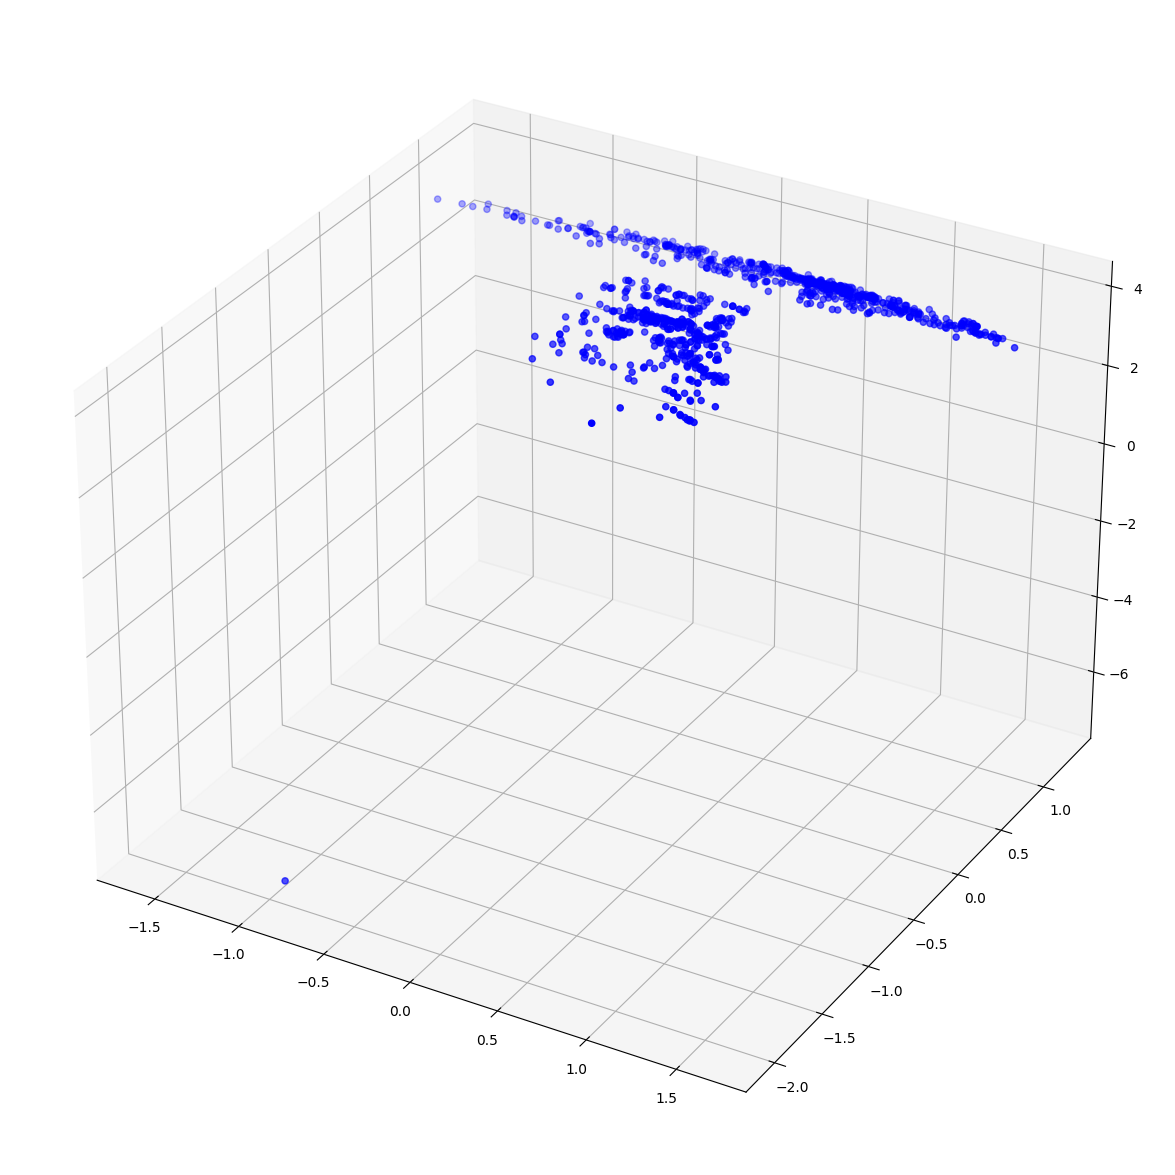

In [91]:
################################################################################################################################
# Step 3: Essential Matrix Decomposition & Step 4: Triangulation
################################################################################################################################
U, S, VT = np.linalg.svd(best_E, full_matrices=True)

W = np.array([[0.0, -1.0, 0.0],
              [1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0]
              ])

Z = np.array([[0.0, 1.0, 0.0],
              [-1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0]
              ])

P = [
    np.append(U@W@VT, U[:,2].reshape(3,1), axis=1),
    np.append(U@W@VT, -U[:,2].reshape(3,1), axis=1),
    np.append(U@W.T@VT, U[:,2].reshape(3,1), axis=1),
    np.append(U@W.T@VT, -U[:,2].reshape(3,1), axis=1),
]

print('candidate for camera matrix\n', P)

E_init = np.append(np.eye(3), np.zeros((3,1)), axis=1)
E_cnt = [0,0,0,0]
for i in range(4):
    tmp = P[i]
    for j in range(len(inlier)):
        A = np.array([
            norm_q1[0,inlier[j]]*E_init[2] - E_init[0],
            norm_q1[1,inlier[j]]*E_init[2] - E_init[1],
            norm_q2[0,inlier[j]]*tmp[2] - tmp[0],
            norm_q2[1,inlier[j]]*tmp[2] - tmp[1]])
        U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
        X = VT_A[3]/VT_A[3,3]
        if X[2] > 0 and (tmp@X.T)[2]>0:
            E_cnt[i] += 1

print(E_cnt)
E = P[np.argmax(E_cnt)]

inlier_X = []
_inlier = []

for i in range(len(inlier)):
    A = np.array((
        norm_q1[0,inlier[i]]*E_init[2] - E_init[0],
        norm_q1[1,inlier[i]]*E_init[2] - E_init[1],
        norm_q2[0,inlier[i]]*E[2] - E[0],
        norm_q2[1,inlier[i]]*E[2] - E[1]))
    U_A, S_A, VT_A = np.linalg.svd(A, full_matrices=True)
    X = VT_A[3]/VT_A[3,3]
    inlier_X.append(X)

p3ds = np.array(inlier_X).T

# visualize
X = np.array([])
Y = np.array([])
Z = np.array([])
X = np.concatenate((X, p3ds[0]))
Y = np.concatenate((Y, p3ds[1]))
Z = np.concatenate((Z, p3ds[2]))

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, c='b', marker='o') 
# plt.show()
plt.savefig('./results/3D_result.jpg')

In [ ]:
################################################################################################################################
# Step 5: Growing Steps
################################################################################################################################

